In [2]:
import os
import pyemu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import flopy.utils.binaryfile as bf
from shutil import copyfile
%matplotlib inline
#%matplotlib notebook #allows zooming, but opens many figures

In [3]:
extdir=r'S:\Kitlasten2020_WRR\model\external_files\Carson_Valley'

In [4]:
#New WR acres
#get irrigation acres from wr_cell_frac
# cell frac in pandas
celldf=pd.read_csv(os.path.join(extdir,'wr_cell_frac.txt'))
celldf.columns=celldf.columns.str.lower()
celldf.wrname=celldf.wrname.apply(lambda x: x.lower().replace('_',''))
celldf.set_index('wrname',inplace=True)
celldf.drop(['unnamed: 0'],axis=1,inplace=True)
celldf['row']=celldf['row']-1
celldf['col']=celldf['col']-1
wracres=celldf.loc[:,'wr_acres']
wracres=wracres.groupby(by='wrname').mean()

In [5]:
def get_wrdf(irrfile,wracres):
    with open(irrfile,'r') as f:
        head=f.readline().replace('#','').strip().replace('  ',' ').replace('  ',' ').split(' ')
    
    irr=pd.read_csv(irrfile,skiprows=[0],names=head,delim_whitespace=True)
    irr.index=irr.WRname.str.lower()
    irr.drop('WRname',inplace=True,axis=1)
#wrfile='CV-wes-8015trans-WRtable.txt'
# ONLY do this if irr doesn't have wryr
#with open(wrfile,'r') as f:
#    head=f.readline().replace('#','').strip(' ').strip().replace('  ',' ').split(' ')
#wr=pd.read_csv(wrfile,skiprows=[0],names=head,delim_whitespace=True)
#wr.index=wr.WRname.str.lower()
#wr.drop(['WRname','desc','acres','row','col'],inplace=True,axis=1)
#wrdf=irr.merge(wr,left_on='WRname',right_on='WRname')
#wrdf.to_csv(irrfile,sep=' ',na_rep=('NA'))
    wrdf=irr.copy(deep=True)
    wrdf=wrdf.groupby(['WRname']).mean() #gets rid of duplicates by averaging, also drops any non-numeric data not in by
    wrdf.index=wrdf.index.str.lower()
    wrdf['acres']=wracres
    
    # get proper CA WRYR
    propwryr={'478-481': 1864,'487': 1891,'488-490': 1891,'491': 1893,'492-501': 1881,
              '502-507': 1871,'508': 1890,'509-510': 1884,'511': 1893,'512': 1894,
              '513-514': 1864,'515': 1864,'516-517': 1864,'517a': 1871,'518-519': 1864,
              '520-522': 1892,'523-527': 1885,'528': 1894,'529-531': 1866,'532-533': 1865,'534': 1885,'535-536': 1859}
    for wr in propwryr:
        wrdf.loc[wr,'wryr']=propwryr[wr]

    
    
    wrdf.head()
    return(wrdf)

In [16]:
def sumtab(pst,e,real='base'):
        '''this is for ensembles only, i.e. pest during calibration period'''
    pie=[]
    plab=[]
    res={}
    ensemble=(pst.filename.replace('pst','.{}.{}.csv'.format(e,'obs')).replace('..','.').replace('..','.')) #double dot for noptmax=0
    if os.path.exists(ensemble):
        try:
            pen=pd.read_csv(ensemble.replace('obs','par'),low_memory=False)
            pen.set_index('real_name',inplace=True)
            pen=pen.T
        except:
            pen=pd.read_csv(ensemble.replace('obs.csv','base.par'),index_col=0,
                            low_memory=False,header=0,names=['parnme','base'],usecols=[0,1],delim_whitespace=True)
            
            
        en=pd.read_csv(ensemble,low_memory=False)
        en.set_index('real_name',inplace=True)
        en=en.T
        en.columns=en.columns.astype(str)
        
        print(ensemble)
    elif 'rns'==e: #ensemble name is dumb
        #try intermediate partial ensemble from rns
        #does not contain lambda test results, only "remaining ensemble" reals
        rns=pyemu.utils.read_pestpp_runstorage(pst.filename.replace('.pst','.rns'),irun='all')
        done=[r for r in rns[1].index if rns[1].loc[r,:].mean()!=0]
        pen=rns[0].loc[done,:]
        en=rns[1].loc[done,:]
        pen=pen.T
        en=en.T
        en.columns=en.columns.astype(str)
        
        print('using rns file {} with {} reals complete'.format(pst.filename.replace('.pst','.rns'),len(en.columns)))
    if real=='base':
        try:
            sim=en.loc[:,'base']
        except:
            sim=en.loc[:,:].mean(axis=1)
            print('cannot find base real, using mean')
    elif real=='mean':
        sim=en.loc[:,:].mean(axis=1)
    tres=[]
    print('GROUP CONTRIBUTIONS TO PHI ({})'.format(real))
    for g in sorted(list(set(obs['obgnme']))):
        mask=[o for o in obs.index if obs.loc[o,'obgnme']==g]
        res[g]=(sim.loc[mask]-obs.loc[mask,'obsval']).to_frame()
        res[g].columns=['res']
        if 'less_' not in g:
            wres=(res[g].loc[:,'res']*obs.loc[mask,'weight'])**2
        else:
            m=[i for i in mask if obs.loc[i,'obsval']<sim.loc[i]]
            wres=(res[g].loc[m,'res']*obs.loc[m,'weight'])**2
        print('{0:<20}: sum={1:>10.2e}, std={2:>10.2e}'.format(g,wres.sum(),wres.std()))
        pie.append(wres.sum())
        plab.append(g)
        tres.append(wres.sum())
    total=np.sum(tres)
    print('total {0:.2e}, {1:.2e}'.format(total,np.std(tres)))
    plt.pie(pie,labels=plab)
    plt.show()
    en['res_real']=sim
    return(pen,en,res)
    

In [6]:
wrdf=get_wrdf(os.path.join(extdir,'CV-wes-8015trans-irrigation-fracsup.txt'),wracres)
wrdf.head(10)

,iseg,wellnum,welllay,wellrow,wellcol,startyr,dpt,swu,swufrac,pctsup,swfrfrac,swfr,welleff,wryr,row,col,acres
WRname,,,,,,,,,,,,,,,,,
056,998,NaN,NaN,NaN,NaN,NaN,0.010929,0.007726,0.767833,NaN,0.993391,0.999725,NaN,1880.0,158.0,84.0,1.9875
057a,1051,NaN,NaN,NaN,NaN,NaN,0.027982,0.051638,0.774693,NaN,0.907559,0.089143,NaN,1889.0,155.0,85.0,97.0679
058a,1157,NaN,NaN,NaN,NaN,NaN,0.022108,0.007892,0.855151,NaN,0.854737,0.108686,NaN,1916.0,150.0,86.0,99.7208
059,999,NaN,NaN,NaN,NaN,NaN,0.158524,0.020658,0.866762,NaN,0.872975,0.693674,NaN,1880.0,159.0,84.0,6.2327
060,1116,NaN,NaN,NaN,NaN,NaN,0.156815,0.024127,0.924215,NaN,0.857488,0.753628,NaN,1900.0,159.0,83.0,12.5040
061,1052,2.0,4.0,151.0,76.0,1981.333333,0.000052,0.092544,0.900002,0.81,0.878824,0.211569,0.367081,1889.0,152.0,78.0,38.3758
063,743,NaN,NaN,NaN,NaN,NaN,0.101008,0.031664,0.883223,NaN,0.791365,0.492795,NaN,1860.0,155.0,77.0,162.1254
064,762,5.0,4.0,151.0,76.0,1981.333333,0.015966,0.023146,0.797631,0.81,0.929672,0.963813,0.373743,1861.0,150.0,76.0,104.5396
065,905,8.0,4.0,151.0,76.0,1981.333333,0.018496,0.019191,0.850717,0.81,0.856266,0.979470,0.566241,1875.0,148.0,78.0,40.8601


## scenario results

In [7]:
def get_scens():
    outdir=r'S:\Kitlasten2020_WRR\output'
    scens={'hist':os.path.join(outdir,'output_MSGSF_hist'),
                 '1C':os.path.join(outdir,'output_MSGSF_1C'),
                 '2C':os.path.join(outdir,'output_MSGSF_2C'),
                 '3C':os.path.join(outdir,'output_MSGSF_3C'),
                 '4C':os.path.join(outdir,'output_MSGSF_4C'),
                 '5C':os.path.join(outdir,'output_MSGSF_5C')}
    scenlist=['hist','1C','2C','3C','4C','5C']
    return(scenlist,scens)

In [ ]:
#run post procs, takes a while
#sim_wrts_extract_final.py

In [9]:
# get ET data from post-proc
etdf={}

scenlist,scens=get_scens()

resdir=r'S:\Kitlasten2020_WRR\results_dT'
if not os.path.exists(resdir):
    os.mkdir(resdir)
    
#get et from post-processor annual cubic feet (pre-proc pcpet incorporated in same sim_wret_ts.txt file)
for scen in scenlist:
    if not os.path.exists(os.path.join(resdir,scen)):
        os.mkdir(os.path.join(resdir,scen))
    df=pd.read_csv(os.path.join(scens[scen],'sim_wret_ts.txt'),delim_whitespace=True,usecols=[0,1,2,3,4,5],index_col=False)
    
    d8str=df.loc[:,'obnme'].str.split('_').str.get(-1)+'0101'
    df['yr']=pd.to_datetime(d8str,format='%y%m%d')
    df['wr']=df.loc[:,'obnme'].str.split('_',1).str.get(1).str.rsplit('_',1).str.get(0)
    df['wr_yr']=df.loc[:,'obnme'].str.split('_',1).str.get(1)
    df=df.merge(wrdf,left_on='wr',right_on='WRname')
    etdf[scen]=df.copy(deep=True)
    
#get deliv from post-processed file (annual cubic feet)
for scen in scenlist:
    df=pd.read_csv(os.path.join(scens[scen],'sim_swgag_ts.txt'),delim_whitespace=True,usecols=[0,1,2,3],index_col=False)
    d8str=df.loc[:,'obnme'].str.split('_').str.get(-1)+'0101'
    df['yr']=pd.to_datetime(d8str,format='%y%m%d')
    df['wr']=df.loc[:,'obnme'].str.split('_',1).str.get(1).str.rsplit('_',1).str.get(0)
    df['wr_yr']=df.loc[:,'obnme'].str.split('_',1).str.get(1)
    df.drop(['obnme','yr','wr'],inplace=True,axis=1)
    etdf[scen]=df.merge(etdf[scen],left_on='wr_yr',right_on='wr_yr')
#     etdf[scen]=deliv.loc[:,['hist_del']].merge(etdf[scen],left_on='wr',right_on='wr')
    
    
#data frame for each wr and each yr
pd.set_option('precision', 3)
for scen in scenlist:
    #these now in feet per year
    bscen='hist'
    etdf[scen]['tot_et_fpy']=etdf[scen]['total_et']/etdf[scen]['acres']/43560
    etdf[scen]['tot_del_fpy']=etdf[scen]['tot_del']/etdf[scen]['acres']/43560
    etdf[scen]['sw_del_fpy']=etdf[scen]['sw_del']/etdf[scen]['acres']/43560
    etdf[scen]['well_del_fpy']=etdf[scen]['well_del']/etdf[scen]['acres']/43560

    etdf[bscen]['tot_et_fpy']=etdf[bscen]['total_et']/etdf[bscen]['acres']/43560
    etdf[bscen]['tot_del_fpy']=etdf[bscen]['tot_del']/etdf[bscen]['acres']/43560
    etdf[bscen]['sw_del_fpy']=etdf[bscen]['sw_del']/etdf[bscen]['acres']/43560
    etdf[bscen]['well_del_fpy']=etdf[bscen]['well_del']/etdf[bscen]['acres']/43560
    
    # difference from historical
    etdf[scen].index=etdf[scen].obnme
    etdf[bscen].index=etdf[bscen].obnme
    etdf[scen]['tot_et_fpy_scen_hist']=etdf[scen]['tot_et_fpy']-etdf[bscen]['tot_et_fpy']
    etdf[scen]['tot_et_volume_scen_hist']=etdf[scen]['total_et']-etdf[bscen]['total_et']
    etdf[scen]['tot_del_scen_hist']=etdf[scen]['tot_del']-etdf[bscen]['tot_del']
    etdf[scen]['sw_del_scen_hist']=etdf[scen]['sw_del']-etdf[bscen]['sw_del']
    etdf[scen]['well_del_scen_hist']=etdf[scen]['well_del']-etdf[bscen]['well_del']
    etdf[scen]['tot_del_fpy_scen_hist']=etdf[scen]['tot_del_fpy']-etdf[bscen]['tot_del_fpy']
    etdf[scen]['sw_del_fpy_scen_hist']=etdf[scen]['sw_del_fpy']-etdf[bscen]['sw_del_fpy']
    etdf[scen]['well_del_fpy_scen_hist']=etdf[scen]['well_del_fpy']-etdf[bscen]['well_del_fpy']
    
    etdf[scen].drop('wr_yr',inplace=True,axis=1)
    
    mask=[i for i in etdf[scen].index if etdf[scen].loc[i,'tot_et_fpy']>4]
    print('{0} has {1:.1f} ft3 et by WR with rate > 4 ft/yr'.format(scen,etdf[scen].loc[mask,'total_et'].divide(43560).mean())) #average volume leaving from WR with ET>4 in ac-ft/yr


hist has 360.9 ft3 et by WR with rate > 4 ft/yr
1C has 376.1 ft3 et by WR with rate > 4 ft/yr
2C has 376.2 ft3 et by WR with rate > 4 ft/yr
3C has 392.9 ft3 et by WR with rate > 4 ft/yr
4C has 405.0 ft3 et by WR with rate > 4 ft/yr
5C has 414.8 ft3 et by WR with rate > 4 ft/yr


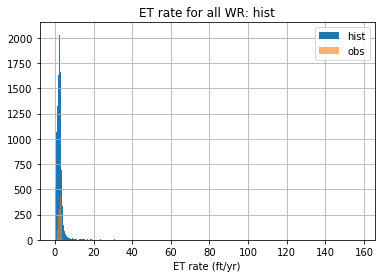

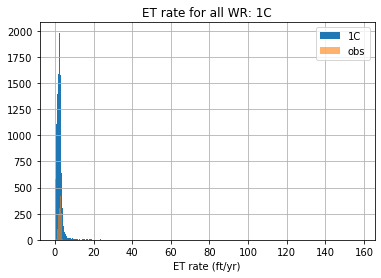

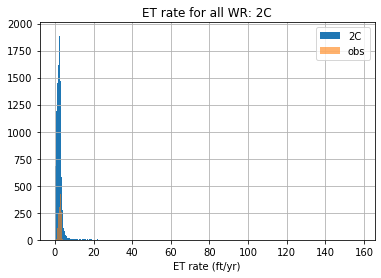

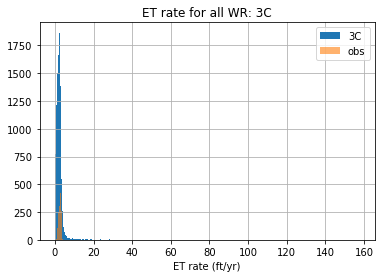

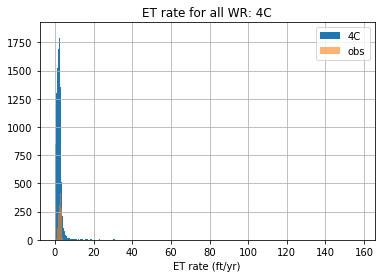

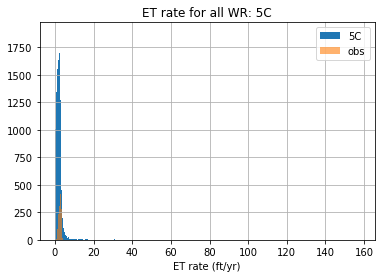

In [18]:
# get results from pest to compare obs
pestname='CV_cal_finalpars.pst'
pst=pyemu.Pst(os.path.join(r'S:\CarsonValley\MSMF\WftS_archive\ancillary\pest',pestname))
obs=pst.observation_data
for scen in scenlist:
    etdf[scen].hist('tot_et_fpy',bins=np.arange(etdf[scen]['tot_et_fpy'].min(),etdf[scen]['tot_et_fpy'].max(),0.25))
    plt.title('ET rate for all WR: {}'.format(scen))
    plt.xlabel('ET rate (ft/yr)')
    wrrtobs=[o for o in obs.index if obs.loc[o,'obgnme']=='wrrt']
    obs.loc[wrrtobs,'obsval'].hist(bins=np.arange(etdf[scen]['tot_et_fpy'].min(),etdf[scen]['tot_et_fpy'].max(),0.25),alpha=0.6)
    plt.legend([scen,'obs'])
    plt.show()

In [10]:
#write etdf file, copy inflow results (check agains intabs), build df of mean values for each WR
mdflist=[]
wrcols=['acres','tot_del','sw_del','well_del','total_et','swet','wellet','gwet','pcpet','pctsup','wryr',
        'tot_del_scen_hist','sw_del_scen_hist','well_del_scen_hist',
        'tot_del_fpy_scen_hist','sw_del_fpy_scen_hist','well_del_fpy_scen_hist',
        'tot_et_fpy_scen_hist','tot_et_volume_scen_hist']
for scen in scenlist:
    print(scen)
    etdf[scen].to_csv(os.path.join(resdir,scen,scen+'_etdf.csv'),columns=[c for c in wrcols])
    mdf=etdf[scen].groupby('wr').mean() #wr becomes index, don't include in cols
    print(mdf.head())
    mdf.to_csv(os.path.join(resdir,scen,scen+'_mean_etdf.csv'),columns=[c for c in wrcols])
    copyfile(os.path.join('..\\','runs',scens[scen],'CV-wes-8015trans-10311000.sgag'),os.path.join(resdir,scen,scen+'-10311000.sgag'))
    copyfile(os.path.join('..\\','runs',scens[scen],'CV-wes-8015trans-10309000.sgag'),os.path.join(resdir,scen,scen+'-10309000.sgag'))
    copyfile(os.path.join('..\\','runs',scens[scen],'CV-wes-8015trans-10310000.sgag'),os.path.join(resdir,scen,scen+'-10310000.sgag'))
    
    mdf.columns=['dT'+scen+'_'+c for c in mdf.columns]
    mdflist.append(mdf[['dT'+scen+'_sw_del_fpy_scen_hist','dT'+scen+'_well_del_fpy_scen_hist','dT'+scen+'_tot_del_fpy_scen_hist','dT'+scen+'_tot_et_fpy_scen_hist']])

hist
        tot_del     sw_del  well_del   total_et        gwet  wellet  \
wr                                                                    
056   6.878e+04  6.878e+04       0.0  1.954e+05       0.000     0.0   
057a  2.301e+07  2.301e+07       0.0  2.424e+06  573295.514     0.0   
058a  3.173e+06  3.173e+06       0.0  4.321e+05       0.000     0.0   
059   6.364e+05  6.364e+05       0.0  5.371e+05   53739.672     0.0   
060   1.287e+06  1.287e+06       0.0  1.591e+06  686079.174     0.0   

           swet       pcpet  iseg  wellnum  ...  sw_del_fpy  well_del_fpy  \
wr                                          ...                             
056   5.872e+04  136682.809   998      NaN  ...       0.794           0.0   
057a  1.688e+06  162185.118  1051      NaN  ...       5.441           0.0   
058a  2.638e+05  168357.852  1157      NaN  ...       0.730           0.0   
059   3.666e+05  116792.672   999      NaN  ...       2.344           0.0   
060   7.870e+05  118258.771  1116  

        tot_del     sw_del  well_del   total_et        gwet  wellet  \
wr                                                                    
056   5.691e+04  5.691e+04       0.0  1.855e+05       0.000     0.0   
057a  1.886e+07  1.886e+07       0.0  1.731e+06  175665.236     0.0   
058a  2.475e+06  2.475e+06       0.0  3.749e+05       0.000     0.0   
059   5.314e+05  5.314e+05       0.0  4.774e+05   54345.728     0.0   
060   1.028e+06  1.028e+06       0.0  1.438e+06  690201.264     0.0   

           swet       pcpet  iseg  wellnum  ...  sw_del_fpy  well_del_fpy  \
wr                                          ...                             
056   4.881e+04  136682.809   998      NaN  ...       0.657           0.0   
057a  1.393e+06  162185.118  1051      NaN  ...       4.461           0.0   
058a  2.065e+05  168357.852  1157      NaN  ...       0.570           0.0   
059   3.062e+05  116792.672   999      NaN  ...       1.957           0.0   
060   6.299e+05  118258.771  1116      N

In [11]:
#define wr decades and WR with rotations
wrdec=[0,1850,1860,1870,1880,1890,1900,2000]
wrdeclab=['1850s\nand prior','1860s','1870s','1880s','1890s','1900s\nand later']
rotwr=['544','578','559','532-533','604','555','554','557','556','553','516-517','492-501','491','529-531','542','558','535-536','523-527','543','540','534','546','508','545','528','561','513-514','568','540a','560','518-519','562','563','564','502-507','566','565','517a','487','567','478-481','520-522','537','488-490','539','511','512','515','509-510','538']
etdf[scen]['wrdec']=False
for scen in etdf:
    for i,d in enumerate(wrdec):
        mask=[x for x in etdf[scen].index if wrdec[i]<=etdf[scen].loc[x,'wryr']<wrdec[i+1]]
        #leave "real" decade, lump prior to 1850 into 1850
        etdf[scen].loc[mask,'wrdecade']=d
        etdf[scen].loc[mask,'wrdec']=max(1850,d)

In [12]:
#construct intermediate dfs for rates, volumes, and percentages of sw, wells, and total
nyrs=36.22221218331232
sw={}
well={}
tot={}
vsw={}
vwell={}
vtot={}
psw={}
pwell={}
ptot={}
for scen in scenlist[1:]:
    #depth based, mean (already normalized by acres)
    decdf=etdf[scen].loc[:,:].groupby('wrdec').mean()
    
    well[scen]=decdf.loc[:,'well_del_fpy_scen_hist']
    sw[scen]=decdf.loc[:,'sw_del_fpy_scen_hist']
    tot[scen]=decdf.loc[:,'tot_del_fpy_scen_hist']

#volume based total delivery, sum all in decade, divide by years for average volume
histdf=etdf['hist'].loc[:,:].groupby('wrdec').sum()
for scen in scenlist[1:]:
    decdf=etdf[scen].loc[:,:].groupby('wrdec').sum()/43560/nyrs #is in cf, convert to ac-ft on the fly, divide by 36 year sim period
    
    vwell[scen]=decdf.loc[:,'well_del_scen_hist']
    vsw[scen]=decdf.loc[:,'sw_del_scen_hist']
    vtot[scen]=decdf.loc[:,'tot_del_scen_hist']
    
    pwell[scen]=(decdf.loc[:,'well_del_scen_hist'].divide(histdf.loc[:,'well_del']))*100
    psw[scen]=(decdf.loc[:,'sw_del_scen_hist'].divide(histdf.loc[:,'sw_del']))*100
    ptot[scen]=(decdf.loc[:,'tot_del_scen_hist'].divide(histdf.loc[:,'tot_del']))*100
    

Text(0.5, 0, 'priority decade')

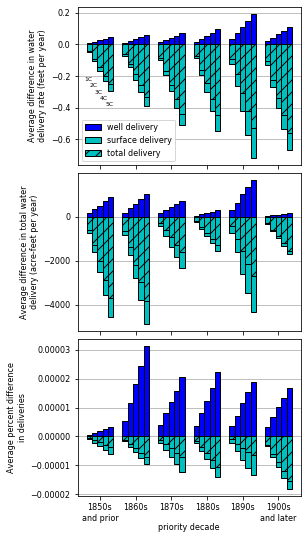

In [13]:
# Change in deliveries figure
fs=8
fig,ax=plt.subplots(3,1,figsize=(4,9),gridspec_kw = {'wspace':0, 'hspace':0.05})
for i,(t,m) in enumerate(zip(['Average difference in water\ndelivery rate (feet per year)',
                              'Average difference in total water\ndelivery (acre-feet per year)',
                              'Average percent difference\nin deliveries'],[[well,sw,tot],[vwell,vsw,vtot],[pwell,psw,ptot]])):
    pd.DataFrame(m[0]).plot(kind='bar',ax=ax[i],legend=False,color='b',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[1]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[2]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',hatch='//',sharex=True,fontsize=fs,width=0.75)

    ax[i].grid(True,which='major',axis='y')
    ax[i].set_axisbelow(True)
    
    ax[i].set_ylabel(t,fontsize=fs)

#ax[0].set_title('Difference in deliveries to water rights by decade',fontsize=fs+2)
for x,y,dtlab in zip([-0.45,-0.3,-0.15,0,0.16],[-0.23,-0.27,-0.31,-0.35,-0.39],['1C','2C','3C','4C','5C']):
    ax[0].text(x,y,dtlab,fontsize=fs-2,rotation=0)
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[0:len(h):5],['well delivery','surface delivery','total delivery'],loc=3,fontsize=fs)
ax[i].xaxis.set_major_formatter(ticker.FixedFormatter(wrdeclab))        
plt.setp(ax[i].get_xticklabels(), rotation=0)
ax[i].set_xlabel('priority decade',fontsize=fs,labelpad=0)

# get actual demand time series for each scenario
dmd={}
for scen in scenlist:
    for fn in os.listdir(os.path.join(modir,'MSGSF','MSGSF_'+scen,'tabfiles_'+scen)):
        if 'demand' in fn:
            data=fn.split('-')
            if len(data)==7:
                wr=data[4].lower()
            elif len(data)==8:
                wr='-'.join(data[4:6]).lower()
            else:
                print('yerdum {}'.format(derp))
            ts=pd.read_csv(os.path.join(modir,'MSGSF','MSGSF_'+scen,'tabfiles_'+scen,fn),delim_whitespace=True, usecols=[0,1,3],names=['simday','dmd','date'])
            ts['date']=pd.to_datetime(ts['date'])
            ts.set_index('date',inplace=True)
            ats=ts.resample('D').interpolate(method='backfill')
            dmd[wr]=ats['dmd'].mean()
dmddf=pd.DataFrame.from_dict(dmd,orient='index',columns=['dmd'])

In [28]:
# convert to hectare-meters
hmdflist=[]
hetdf={}
cuft2ham=1/((3.28084**3)*10000)
wrcols=['acres','tot_del','sw_del','well_del','total_et','swet','wellet','gwet','pcpet','pctsup','wryr','wrdec',
        'tot_del_scen_hist','sw_del_scen_hist','well_del_scen_hist',
        'tot_del_mpy_scen_hist','sw_del_mpy_scen_hist','sw_del_pct_scen_hist','well_del_mpy_scen_hist',
        'tot_et_mpy_scen_hist','tot_et_volume_scen_hist','tot_et_pct_scen_hist']

for scen in scenlist:
    hetdf[scen]=etdf[scen].copy(deep=True)
    hetdf[scen]['ha']=etdf[scen]['acres'].multiply(43560/(3.28084**2)/10000) #convert acres to ha
    hetdf[scen][['tot_del','sw_del','well_del','total_et','swet','wellet','gwet','pcpet',
                'tot_del_scen_hist','sw_del_scen_hist','well_del_scen_hist',
                'tot_et_volume_scen_hist']]=etdf[scen][['tot_del','sw_del','well_del',
                'total_et','swet','wellet','gwet','pcpet',
                'tot_del_scen_hist','sw_del_scen_hist','well_del_scen_hist',
                'tot_et_volume_scen_hist']].multiply(cuft2ham)
    hetdf[scen][['tot_del_mpy_scen_hist','sw_del_mpy_scen_hist','well_del_mpy_scen_hist',
                'tot_et_mpy_scen_hist']]=etdf[scen][['tot_del_fpy_scen_hist','sw_del_fpy_scen_hist',
                'well_del_fpy_scen_hist','tot_et_fpy_scen_hist']].divide(3.28084)
    
for scen in scenlist:
    hetdf[scen]['sw_del_pct_scen_hist']=hetdf[scen]['sw_del_scen_hist'].divide(hetdf['hist']['sw_del'])
    hetdf[scen]['tot_et_pct_scen_hist']=hetdf[scen]['tot_et_volume_scen_hist'].divide(hetdf['hist']['total_et'])
    hetdf[scen].to_csv(os.path.join(resdir,scen,'dT'+scen+'_etdf_hamy.csv'),columns=[c for c in wrcols])
    hmdf=hetdf[scen].groupby('wr').mean() # mean value for wr. wr becomes index, don't include in cols
    
    # as fraction of demand
    #hmdf['swdmd']=dmddf['dmd'].multiply(365.25).multiply(0.000002832) #mean cfd to hampy
    #hmdf['swdmd_frac_scen_hist']=hmdf['sw_del_scen_hist'].divide(hmdf['swdmd'])
    #hmdf['swdmd_frac_scen']=hmdf['sw_del'].divide(hmdf['swdmd'])
    
    hmdf.to_csv(os.path.join(resdir,scen,'dT'+scen+'_mean_etdf_hamy.csv'),float_format='%.4f',columns=[c for c in wrcols])#+['swdmd_frac_scen_hist','swdmd_frac_scen'])
    hmdf.columns=['dT'+scen+'_'+c for c in hmdf.columns]
    hmdflist.append(hmdf[['dT'+scen+'_sw_del_mpy_scen_hist','dT'+scen+'_sw_del_pct_scen_hist','dT'+scen+'_tot_et_pct_scen_hist','dT'+scen+'_well_del_mpy_scen_hist','dT'+scen+'_tot_del_mpy_scen_hist','dT'+scen+'_tot_et_mpy_scen_hist']])#,'dT'+scen+'_swdmd_frac_scen_hist','dT'+scen+'_swdmd_frac_scen']])

In [118]:
hetdf[scen].columns

Index(['tot_del', 'sw_del', 'well_del', 'obnme', 'total_et', 'gwet', 'wellet',
       'swet', 'pcpet', 'yr', 'wr', 'iseg', 'wellnum', 'welllay', 'wellrow',
       'wellcol', 'startyr', 'dpt', 'swu', 'swufrac', 'pctsup', 'swfrfrac',
       'swfr', 'welleff', 'wryr', 'row', 'col', 'acres', 'tot_et_fpy',
       'tot_del_fpy', 'sw_del_fpy', 'well_del_fpy', 'tot_et_fpy_scen_hist',
       'tot_et_volume_scen_hist', 'tot_del_scen_hist', 'sw_del_scen_hist',
       'well_del_scen_hist', 'tot_del_fpy_scen_hist', 'sw_del_fpy_scen_hist',
       'well_del_fpy_scen_hist', 'wrdec', 'wrdecade', 'ha',
       'tot_del_mpy_scen_hist', 'sw_del_mpy_scen_hist',
       'well_del_mpy_scen_hist', 'tot_et_mpy_scen_hist',
       'sw_del_pct_scen_hist', 'tot_et_pct_scen_hist', 'swr', 'tot_swd',
       'swu_vol', 'swr_vol'],
      dtype='object')

In [114]:
decreed=[i for i in wrdf.index if wrdf.loc[i,'wryr']>1800]
decet=[i for i in hetdf[scen].index if hetdf[scen].loc[i,'wr'] in decreed]

In [116]:
for q in ['sw_del','swet','tot_del','total_et','well_del','wellet','gwet']:    
    print('\nmean annual {}\n'.format(q))
    for scen in scenlist:
        print('{}'.format(float(hetdf[scen].loc[decet,['yr',q]].groupby('yr').sum().mean())))


mean annual sw_del

11640.713680218156
11280.206542446767
10870.677612620997
10437.41846143784
10005.810639152054
9563.135581384078

mean annual swet

2642.0991465020575
2559.8474418341566
2475.3287446942295
2398.6295244784496
2307.1366951128402
2214.4555924748147

mean annual tot_del

13099.649308799555
12832.033062628449
12524.82703571052
12201.15676349207
11872.402699362292
11537.872662501246

mean annual total_et

10423.639037936971
10198.152128726979
9945.02848449556
9675.20577955127
9391.767947706834
9095.578090895266

mean annual well_del

1458.9356285814044
1551.8265201816803
1654.149423089518
1763.7383020542325
1866.5920602102367
1974.7370811171686

mean annual wellet

658.3761021671785
697.2265989112028
741.2630634986496
788.6226369442813
832.916263903297
879.8116191022572

mean annual gwet

6885.246653028559
6703.160951742441
6490.519540063506
6250.036481889365
6013.7978524515165
5763.393743079017


In [70]:
datetime.date(2020,9,30)-datetime.date(2020,4,1)

datetime.timedelta(182)

In [86]:
hetdf[scen].loc[:,'swu'].mean()*182

4.534759355537334

In [115]:
# too big, mask only decreed
print('\nmean annual {}\n'.format('sw demand'))
for scen in scenlist:
    #f/d to ac-ft/day to ac-ft/yr to ha-m/yr
    hetdf[scen]['swu_vol']=hetdf[scen].swu.multiply(hetdf[scen].acres.multiply(43560)).multiply(182/(3.28084**3)/10000)
    hetdf[scen]['swr_vol']=hetdf[scen].swu_vol.multiply(hetdf[scen].swufrac)
    hetdf[scen]['tot_swd']=hetdf[scen].swu_vol+hetdf[scen].swr_vol
    print('{}'.format(float(hetdf[scen].loc[decet,['yr','tot_swd']].groupby('yr').sum().mean())))


mean annual sw demand

36715.37183131711
36715.37183131711
36715.37183131711
36715.37183131711
36715.37183131711
36715.37183131711


In [56]:
sw={}
well={}
tot={}
vsw={}
vwell={}
vtot={}
psw={}
pwell={}
ptot={}
for scen in scenlist[1:]:
    #depth based, mean of all WR in decade
    decdf=hetdf[scen].loc[:,:].groupby('wrdec').mean()
    
    well[scen]=decdf.loc[:,'well_del_mpy_scen_hist']
    sw[scen]=decdf.loc[:,'sw_del_mpy_scen_hist']
    tot[scen]=decdf.loc[:,'tot_del_mpy_scen_hist']
    
#volumne based total delivery, sum of all WR in decade
histdf=hetdf['hist'].loc[:,:].groupby('wrdec').sum()/nyrs
for scen in scenlist[1:]:
    decdf=hetdf[scen].loc[:,:].groupby('wrdec').sum()/nyrs #hetdf in ha-m, divide sum by 36 year sim period
    
    vwell[scen]=decdf.loc[:,'well_del_scen_hist']
    vsw[scen]=decdf.loc[:,'sw_del_scen_hist']
    vtot[scen]=decdf.loc[:,'tot_del_scen_hist']

    pwell[scen]=(decdf.loc[:,'well_del_scen_hist'].divide(histdf.loc[:,'well_del']))*100
    psw[scen]=(decdf.loc[:,'sw_del_scen_hist'].divide(histdf.loc[:,'sw_del']))*100
    ptot[scen]=(decdf.loc[:,'tot_del_scen_hist'].divide(histdf.loc[:,'tot_del']))*100


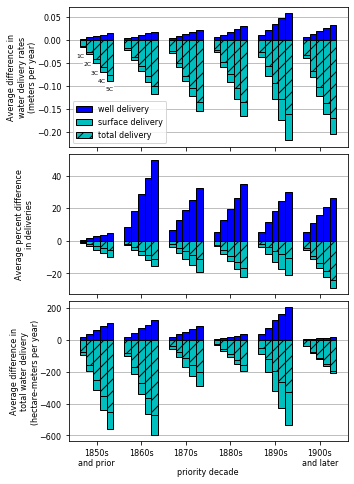

In [57]:
# Change in deliveries ha-m/yr
fs=8
fig,ax=plt.subplots(3,1,figsize=(5,8),gridspec_kw = {'wspace':0.0, 'hspace':0.05})
for i,(t,m) in enumerate(zip(['Average difference in\nwater delivery rates\n(meters per year)',
                              'Average percent difference\nin deliveries\n',
                              'Average difference in\ntotal water delivery\n(hectare-meters per year)'],[[well,sw,tot],[pwell,psw,ptot],[vwell,vsw,vtot]])):
    pd.DataFrame(m[0]).plot(kind='bar',ax=ax[i],legend=False,color='b',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[1]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[2]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',hatch='//',sharex=True,fontsize=fs,width=0.75)

    ax[i].grid(True,which='major',axis='y')
    ax[i].set_axisbelow(True)
    
    ax[i].set_ylabel(t,fontsize=fs,labelpad=0)

#ax[0].set_title('Difference in deliveries to water rights by decade',fontsize=fs+2)
xstart=-0.46
xinc=0.165
ystart=-0.038
yinc=0.018
for x,y,dtlab in zip([xstart+i*xinc for i in range(0,5)],[ystart-j*yinc for j in range(0,5)],['1C','2C','3C','4C','5C']):
    t=ax[0].text(x,y,dtlab,fontsize=fs-2,rotation=0,bbox=dict(boxstyle='square,pad=0',facecolor='white',edgecolor='white'))
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[0:len(h):5],['well delivery','surface delivery','total delivery'],loc=3,fontsize=fs)
ax[i].xaxis.set_major_formatter(ticker.FixedFormatter(wrdeclab))        
plt.setp(ax[i].get_xticklabels(), rotation=0)
ax[i].set_xlabel('priority decade',fontsize=fs,labelpad=0)
fig.savefig(os.path.join(resdir,'dT_delivery.png'), dpi=600,bbox_inches='tight')

In [36]:
a=[]
for i,scen in enumerate(scenlist[1:]):
    a.append(hetdf[scen]['sw_del'].sum()-hetdf[scenlist[i-1]]['sw_del'].sum())
    print(scen,hetdf[scen]['sw_del'].sum(),(hetdf[scen]['sw_del'].sum()-hetdf[scenlist[i-1]]['sw_del'].sum()))

1C 539140.318260802 71621.61895476154
2C 522280.69651518954 -31701.04648312513
3C 504316.28215499315 -34824.0361058088
4C 486117.68324047665 -36163.013274712896
5C 467518.6993060404 -36797.582848952734


In [ ]:
hetdf[scen]['sw_del'].keys()

In [ ]:
# concat and save select means
mdf=pd.concat(mdflist,axis=1,sort=True)
hmdf=pd.concat(hmdflist,axis=1,sort=True)
hmdf['wr']=hmdf.index
hmdf['wr']=hmdf['wr'].apply(lambda x:'wr_'+x)
hmdf.set_index('wr',inplace=True)

mdf.to_csv(os.path.join(resdir,'mean_wrdf.csv'))
hmdf.to_csv(os.path.join(resdir,'mean_wrdf_hamy.csv'))

In [ ]:
hmdf.loc[:,'dT5C_swdmd_frac_scen_hist'].hist()
plt.ylabel('count')
plt.xlabel('change in SW delivery\n(SW_scenario-SW_hist)/(demand)')

In [ ]:
#difference in total_et to explain wells mitigating SW shortfalls
# sum for each wr, divide by years
df={}
wdel={}
wet={}
tet={}
nyrs=36.22221218331232
for scen in scenlist:
    # get average annual depths
    dfsum=hetdf[scen].loc[:,['wr','well_del','wellet','total_et']].groupby('wr').mean()
    dfsum['ha']=hetdf[scen].loc[:,['wr','ha']].groupby('wr').mean()
    df[scen]=dfsum[['well_del','wellet','total_et']].divide(dfsum.ha,axis=0)
for scen in scenlist:
    # difference average annual volumes from historical average annual volumes
    wdel[scen]=(df[scen]['well_del']-df['hist']['well_del'])
    wet[scen]=(df[scen]['wellet']-df['hist']['wellet'])
    tet[scen]=(df[scen]['total_et']-df['hist']['total_et'])
welldel=pd.concat(wdel,axis=1)
wellet=pd.concat(wet,axis=1)
totalet=pd.concat(tet,axis=1)

In [ ]:
out=[w for w in totalet.index if totalet.loc[w,['1C','2C','3C','4C','5C']].max()>0.01] #outliers
print(out)
pmask=[w for w in wrdf.index if wrdf.loc[w,'wellnum']>0 and w not in out and 'gw' not in w]
npmask=[w for w in wrdf.index if w not in pmask and w not in out]
print(len(pmask),len(npmask))

for scen in scenlist:
    print('\n'+scen)
    df=pd.concat([wellet.loc[:,scen],totalet.loc[:,scen]],axis=1)
    df.columns=['wellet','total_et']
    print('mean decrease in total_et')
    print('pmp: {}, nopmp: {}'.format(df.loc[pmask,'total_et'].mean(),df.loc[npmask,'total_et'].mean()))
    print('decrease in pmp et is {} of nopmp'.format(df.loc[pmask,'total_et'].mean()/df.loc[npmask,'total_et'].mean()))
    
    
    
    p=df.loc[pmask,'wellet'].divide(df.loc[pmask,'total_et'])
    print(p.loc[pmask].mean())
    p.hist()
    


In [ ]:
#ratio of wellet and total_et to explain wells mitigating SW shortfalls
# sum for each wr, divide by years
wdel={}
wet={}
tet={}
nyrs=36.22221218331232
  
for scen in scenlist:
    df=hetdf[scen].loc[:,['wr','well_del','wellet','total_et']].groupby('wr').sum()
    wdel[scen]=df['well_del']/nyrs
    wet[scen]=df['wellet']/nyrs
    tet[scen]=df['total_et']/nyrs
welldel=pd.concat(wdel,axis=1)
wellet=pd.concat(wet,axis=1)
totalet=pd.concat(tet,axis=1)

In [ ]:
for scen in scenlist:
    print(scen,(totalet['hist'].sum()-totalet[scen].sum())/totalet['hist'].sum())

In [ ]:
out=[]#[w for w in totalet.index if totalet.loc[w,['1C','2C','3C','4C','5C']].max()>300] #outliers
print(out)
pmask=[w for w in wrdf.index if wrdf.loc[w,'wellnum']>0 and w not in out and 'gw' not in w]
npmask=[w for w in wrdf.index if w not in pmask and w not in out]
print(len(pmask),len(npmask))

for scen in scenlist:
    
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    df=pd.concat([wellet.loc[:,scen],totalet.loc[:,scen]],axis=1)
    df.columns=['wellet','total_et']
    
    print(' fraction of total_et from wellet')
    p=df.loc[pmask,'wellet'].divide(df.loc[pmask,'total_et'])
    print(p.loc[pmask].max(),p.loc[pmask].mean(),p.loc[pmask].min())
    
    df.plot(x='total_et',y='wellet',kind='scatter',ax=ax[0],color='g',title=scen+' with pmp',grid='on')
    p.hist(ax=ax[1])
    

In [ ]:
#ET in fpy by decade
wrdec=[1,1000,1850,1860,1870,1880,1890,1900,2000]

dic={}
for i,wd in enumerate(wrdec[:-1]):
    dic[wd]={}
    for scen in scenlist:
        #mask=[o for o in etdf[scen].index]# if etdf[scen].loc[o,'wr'] not in rotwr]
        wryr=etdf[scen].groupby('wryr').mean()
        mask=[d for d in wryr.index if wrdec[i]<=d<wrdec[i+1]]
        dic[wd][scen]=wryr.loc[mask,'tot_del_fpy_scen_hist'].mean()

In [ ]:
pd.DataFrame(dic).T.plot(kind='bar')
plt.grid()
plt.title('ET by priority decade')
plt.ylabel('ET (feet per year)')
plt.xlabel('priority decade')

In [ ]:
mask=[o for o in etdf[scen].index if etdf[scen].loc[o,'wryr']<1000]
etdf['1C'].loc[mask,['tot_del_scen_hist','sw_del_scen_hist','well_del_scen_hist',
        'tot_del_fpy_scen_hist','sw_del_fpy_scen_hist','well_del_fpy_scen_hist',
        'tot_et_fpy_scen_hist','tot_et_volume_scen_hist']].head()

# Now do wells

In [ ]:
# get well areas
welltable=os.path.join(extdir,'CV_PMP_POU_area.csv')
wellarea=pd.read_csv(welltable, dtype={'app': 'object'})
wellarea.app='pmp_'+wellarea.app.str.rjust(5,'0')
wellarea.set_index(wellarea.app,inplace=True)
wellarea.drop('app',inplace=True,axis=1)


In [ ]:
welldf={}

scenlist,scens=get_scens()
    
#get well deliveries from post-processor
for scen in scenlist:
    if not os.path.exists(os.path.join(outdir,scen)):
        os.mkdir(os.path.join(outdir,scen))
    df=pd.read_csv(os.path.join(scens[scen],'sim_pmp_ts.txt'),delim_whitespace=True,index_col=False)
    d8str=df.loc[:,'obnme'].str.split('_').str.get(-1)+'0101'
    df['yr']=pd.to_datetime(d8str,format='%y%m%d')
    df['well']='pmp_'+df.loc[:,'obnme'].str.split('_',1).str.get(0)
    welldf[scen]=df.copy(deep=True)


In [ ]:
# group and write
mdflist=[]
whmdflist=[]
for scen in scenlist:
    print(scen)
    if 'MAR' in scen:
        #base scenario... ie no mar
        bscen=scen.replace('MAR','')
        
        welldf[scen].index=welldf[scen].obnme
        welldf[bscen].index=welldf[bscen].obnme
        welldf[scen]['wypmp_mar_nomar']=welldf[scen]['wypmp']-welldf[bscen]['wypmp']
        
        mdf=welldf[scen].groupby('well').mean() #well becomes index, don't include in cols
        mdf.columns=['dT'+scen+'_'+c for c in mdf.columns]
        mdflist.append(mdf) #well becomes index, don't include in cols
        
        # convert wrpmp to ha-m
        whmdf=mdf.divide((3.28084**3)*10000)
        whmdf['area']= wellarea['Shape_Area_m2']
        whmdf['dT'+scen+'_wypmp_mpy_mar_nomar']=mdf['dT'+scen+'_wypmp_mar_nomar'].divide(3.28084**3).divide(whmdf['area'])
        whmdflist.append(whmdf)
    if 'MAR' not in scen:
        #base scenario... ie hist
        bscen='hist'
        
        welldf[scen].index=welldf[scen].obnme
        welldf[bscen].index=welldf[bscen].obnme
        welldf[scen]['wypmp_scen_hist']=welldf[scen]['wypmp']-welldf[bscen]['wypmp']
        
        mdf=welldf[scen].groupby('well').mean() #well becomes index, don't include in cols
        mdf.columns=['dT'+scen+'_'+c for c in mdf.columns]
        mdflist.append(mdf)
        
        # convert wrpmp to ha-m
        whmdf=mdf.divide((3.28084**3)*10000)
        whmdf['area']= wellarea['Shape_Area_m2']
        whmdf['dT'+scen+'_wypmp_mpy_scen_hist']=mdf['dT'+scen+'_wypmp_scen_hist'].divide(3.28084**3).divide(whmdf['area'])
        whmdflist.append(whmdf)
        


In [ ]:
# concat and save means
mdf=pd.concat(mdflist,axis=1,sort=True)
whmdf=pd.concat(whmdflist,axis=1,sort=True)

mdf.to_csv(os.path.join(outdir,'mean_welldf.csv'))
whmdf.to_csv(os.path.join(outdir,'mean_welldf_hamy.csv'))

# Surface water analysis - historical (w PRMS and without)
Accretion/depletion (outflow-(EF+WF))

Cummulative measured and simulated
    
    A couple sites throughout the basin, but not enough continuous record at any given site 

Average monthly outflows

In [ ]:
modir

In [ ]:
scenlist,scens=get_scens()

In [ ]:
#load measured data from ssf
ssf=pd.read_csv(os.path.join('..\pest','tsproc','CV-wes-8015trans-flows.ssf'),names=['site','date','time','flow'],
                low_memory=False,delim_whitespace=True,comment='#')
ssf.index=pd.to_datetime(ssf['date'])
ssf.flow=ssf.flow

In [ ]:
#data inflow and outflow
outflow=ssf[ssf['site']=='10311000']
outflow=outflow.resample('D').mean().interpolate('backfill')

efin=ssf[ssf['site']=='10309000']
efin=efin.resample('D').mean().interpolate('backfill')

wfin=ssf[ssf['site']=='10310000']
wfin=wfin.resample('D').mean().interpolate('backfill')

accdep=outflow-(efin+wfin)

In [ ]:
import CV_tools
cft2ham=1/(3.28084**3)/10000
simstart=datetime.date(1979,7,2)
#sim inflow and outflow
sim={}
for scen in scenlist:
    print(scen)
    serlist=[]
    sites=['10311000','10309000','10310000']
    names=['outflow','efin','wfin']
    for name,site in zip(names,sites):
        ser=CV_tools.ts2df(site,'.sgag',simstart,rpath=os.path.join(scens[scen])).flow
        ser=ser.resample('D').mean().interpolate('backfill')
        #convert immediately
        serlist.append(ser.multiply(cft2ham))
    sim[scen]=pd.concat(serlist,axis=1)
    sim[scen].columns=names
    sim[scen]['accdep']=sim[scen]['outflow']-(sim[scen]['efin']+sim[scen]['wfin'])

In [ ]:
for scen in sim:  
    ax=sim[scen]['accdep'].plot(fontsize=14)
    ax=plt.title('Accretion and Depletion: {}'.format(scen))
    ax=plt.ylabel('hectare-meters per day')
    ax=plt.legend(['Measured','Simulated'])

In [ ]:
def water_year(m,y):
    if m<10:
        return(str(y))
    else:
        return(str(y+1))

In [ ]:
def water_yrmo(m,y):
    return(y*100+m)

In [ ]:
figsize=(10,5)
annout={}
dif={}
cum={}
cumdif={}
mout={}
mdif={}
ymout={}
ymdif={}
#historical first
scen='hist'
sim[scen]['date']=sim[scen].index
sim[scen]['month']=sim[scen]['date'].dt.month
sim[scen]['year']=sim[scen]['date'].dt.year
sim[scen]['wy']=sim[scen].apply(lambda x: water_year(x['month'],x['year']),axis=1)
sim[scen]['wymo']=sim[scen].apply(lambda x: water_yrmo(x['month'],x['year']),axis=1)
cum[scen]=sim[scen]['outflow'].cumsum()
annout[scen]=sim[scen].loc[:,['outflow','wy']].groupby('wy').sum()
mout[scen]=sim[scen].loc[:,['outflow','month']].groupby('month').sum()
ymout[scen]=sim[scen].loc[:,['outflow','wymo']].groupby('wymo').sum()
#now scenarios
for scen in scenlist:
    sim[scen]['date']=sim[scen].index
    sim[scen]['month']=sim[scen]['date'].dt.month
    sim[scen]['year']=sim[scen]['date'].dt.year
    sim[scen]['wy']=sim[scen].apply(lambda x: water_year(x['month'],x['year']),axis=1)
    sim[scen]['wymo']=sim[scen].apply(lambda x: water_yrmo(x['month'],x['year']),axis=1)
    
    cum[scen]=sim[scen]['outflow'].cumsum()
    cumdif[scen]=cum[scen]-cum['hist']
    annout[scen]=sim[scen].loc[:,['outflow','wy']].groupby('wy').sum()
    dif[scen]=annout[scen]-annout['hist']
    mout[scen]=sim[scen].loc[:,['outflow','month']].groupby('month').sum()
    mdif[scen]=mout[scen]-mout['hist']
    ymout[scen]=sim[scen].loc[:,['outflow','wymo']].groupby('wymo').sum()
    ymdif[scen]=ymout[scen]-ymout['hist']

In [ ]:
efwy=sim['hist'].loc[:,['wy','efin']].groupby('wy').mean()
print(efwy.divide(efwy.mean()))

In [ ]:
a=pd.concat(dif,axis=1,ignore_index=True)
a.columns=scenlist

In [ ]:
leg=[]
fig,ax=plt.subplots(1,1,figsize=figsize)
a.loc[a.index!=1979,['1C','2C','3C','4C','5C']].plot(kind='bar',width=1,ax=ax,figsize=figsize,color=['b','c','g','m','r'])
ax.set(xlabel='Simulation water year',ylabel='Difference in annual outflow\nUSGS gage 10311000 (hectare-meters)')
ytick = range(-2500,7500,500)
#ax.set_yticks(ytick, minor=True )
ax.grid('on', which='both', axis='both' )
ax.tick_params(labelsize=14)
ax.set_axisbelow(True)

In [ ]:
nyrs=(sim['hist'].index[-1]-sim['hist'].index[0]).days/365.2455

In [ ]:
# 35-year average change in annual inflow
for scen in mdif:
    hist=(sim['hist'].loc[:,'efin']+sim['hist'].loc[:,'wfin']).sum()/nyrs
    fd=(sim[scen].loc[:,'efin']+sim[scen].loc[:,'wfin']-((sim['hist'].loc[:,'efin']+sim['hist'].loc[:,'wfin']))).sum()/nyrs
    print(scen,hist,fd,fd/hist)

In [ ]:
# 35-year average change in annual outflow
for scen in sim:
    hist=sim['hist'].loc[:,'outflow'].sum()/nyrs
    fd=(sim[scen].loc[:,'outflow']-sim['hist'].loc[:,'outflow']).sum()/nyrs
    print(scen,hist,fd,fd/hist)

In [ ]:
# 35-year average change in irrigation season inflow
mask=[m for m in sim['hist'].index if sim['hist'].loc[m,'month']>3 and sim['hist'].loc[m,'month']<10]
   
for scen in sim:
    hist=(sim['hist'].loc[mask,'efin']+sim['hist'].loc[mask,'wfin']).sum()/nyrs
    fd=(sim[scen].loc[mask,'efin']+sim[scen].loc[mask,'wfin']-((sim['hist'].loc[mask,'efin']+sim['hist'].loc[mask,'wfin']))).sum()/nyrs
    print(scen,hist,fd,fd/hist)

In [ ]:
# 35-year average change in irrigation season outflow
mask=[m for m in sim['1C'].index if sim['1C'].loc[m,'month']>3 and sim['1C'].loc[m,'month']<10]
   
for scen in sim:
    hist=sim['hist'].loc[mask,'outflow'].sum()/nyrs
    fd=(sim[scen].loc[mask,'outflow']-sim['hist'].loc[mask,'outflow']).sum()/nyrs
    print(scen,hist,fd,fd/hist)

In [ ]:
dates=[datetime.date(1982,10,1),datetime.date(1986,10,1)]
yrmos=[i.year*100+i.month for i in dates]

fig,ax=plt.subplots(1,1,figsize=(10,5))
b=pd.concat([ymdif['1C'],ymdif['3C'],ymdif['5C']],axis=1,ignore_index=True)
b.columns=['1C','3C','5C']

b.loc[yrmos[0]:yrmos[1]].plot(ax=ax,kind='bar',figsize=(10,5),width=0.75)
ax.grid('on', which='both', axis='both' )
ax.set_axisbelow(True)
ax.set(xlabel='Simulation year and month (YEARMO)',ylabel='Difference in cumulative montly outlfow\nUSGS gage 10311000 (hectare-meters)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
b=pd.concat([ymout['hist'],ymout['1C'],ymout['3C'],ymout['5C']],axis=1,ignore_index=True)
b.columns=['hist','1C','3C','5C']

b.loc[yrmos[0]:yrmos[1]].plot(ax=ax,kind='bar',figsize=(10,5),width=0.75)
ax.grid('on', which='both', axis='both' )
ax.set_axisbelow(True)
ax.set(xlabel='Simulation year and month (YEARMO)',ylabel='Cumulative monthly outlfow\nUSGS gage 10311000 (hectare-meters)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=figsize)
sim['hist'].loc[dates[0]:dates[1],'efin'].plot(ax=ax)
sim['3C'].loc[dates[0]:dates[1],'efin'].plot(ax=ax)
sim['5C'].loc[dates[0]:dates[1],'efin'].plot(ax=ax)
ax.legend(['historical','3C','5C'])
ax.set(xlabel='Simulation date',ylabel='East Fork Flows\nUSGS gage 10309000\n(hectare-meters per day)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=figsize)
mo=pd.concat([mdif[s].divide(nyrs) for s in mdif if 'hist' not in s],axis=1,ignore_index=True)
mo.columns=[s for s in scenlist if 'hist' not in s]

mo.plot(ax=ax,kind='bar',figsize=(10,5),width=0.75,color=['b','g','c','m','r'])
ax.grid('on', which='both', axis='both' )
ax.set_axisbelow(True)
ax.set(xlabel='Simulation month',ylabel='Difference in monthly outlfow\nscenario minus historical\nUSGS gage 10311000 (hectare-meters)')

fig.savefig(os.path.join(resdir,'dT_out_dif.png'), dpi=600,bbox_inches='tight')

In [ ]:
for scen in mo:
    print(scen,mo[scen])

In [ ]:
cumsum=pd.concat(cum,axis=1,ignore_index=True)
cumsum.columns=scenlist

fig,ax=plt.subplots(1,1,figsize=figsize)
cumsum.plot(ax=ax)
ax.set(xlabel='Simulation date',ylabel='Cumulative outlfow\nUSGS gage 10311000 (hectare-meters)')

In [ ]:
cd=[]
col=[]
fig,ax=plt.subplots(1,1,figsize=figsize)
for scen in cumsum:
    if scen!='hist':
        cd.append(cumsum[scen]-cumsum['hist'])
        col.append(scen)
cumdif=pd.concat(cd,axis=1,ignore_index=True)
cumdif.columns=col
cumdif.plot(ax=ax,color=['b','g','c','m','r'])
ax.legend(bbox_to_anchor=(.5, .95),loc='center',ncol=len(scenlist)-1)
ax.grid('on', which='both', axis='both' )
ax.set(xlabel='Simulation water year',ylabel='Difference in cumulative outflow from historical\nUSGS gage 10311000 (hectare-meters)')

fig.savefig(os.path.join(resdir,'dT_cumout_dif.png'), dpi=600,bbox_inches='tight')

In [ ]:
cumdif.iloc[-1,:]

# AG delivery analysis
Stacked bar graph of ag deliveries (SW+GW+GWET) binned by priority decade
Histogram of annual deliveries in feet

In [ ]:
pmp=[o for o in obs.index if obs.loc[o,'obgnme']=='pmp']
obs.loc[pmp,'rwell']=obs.loc[pmp,'obsnme'].apply(lambda x: x.split('_')[0])
obs.loc[pmp,:].head()

In [ ]:
wlist=list(set(obs.loc[:,'rwell']))
df=obs.loc[obs['rwell'].isin(wlist),:]       

In [ ]:
df.head() 

In [ ]:
wrdf.head()

In [ ]:
df.loc[df>1800].hist(bins=range(1850,1930,10))
plt.ylabel('number of wells')
plt.xlabel('WR priority year')

In [ ]:
k='fracsup_sw'
ps=[p for p in pars.index if k in pars.loc[p,'pargp']]
pen['9'].loc[ps,:].mean(axis=1).hist()
plt.xlabel('calibrated {} parameter'.format(k))
plt.ylabel('number of values')